<center>

<span style='color:yellow'>
<center><h1> Task-01</h1> </center>
</span>
<h2> Implement a linear regression model to predict the prices of houses based on their square footage and the number of bedrooms and bathrooms. </h2>



Dataset : - https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data


# -----------------------------------------------------------------------------------

</center>



# Loading Libraries



In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning

import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error

# Reading Data

In [2]:
train_path = 'Data/train.csv'
test_path = 'Data/test.csv'

#Load the data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

Base pipeline consists several steps: <br>
1. Data review;
2. Find missing values;
3. Fill missing values;
4. Data cleaning(Find and remove otliers);
5. Encoding(Label and One-hot encoding);
6. Choose the best model.

# Data review

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

We have 1460 rows and 81 columns in the test dataset. float64 - 3 columns, int64 - 35 columns, object - 43 columns. <br>

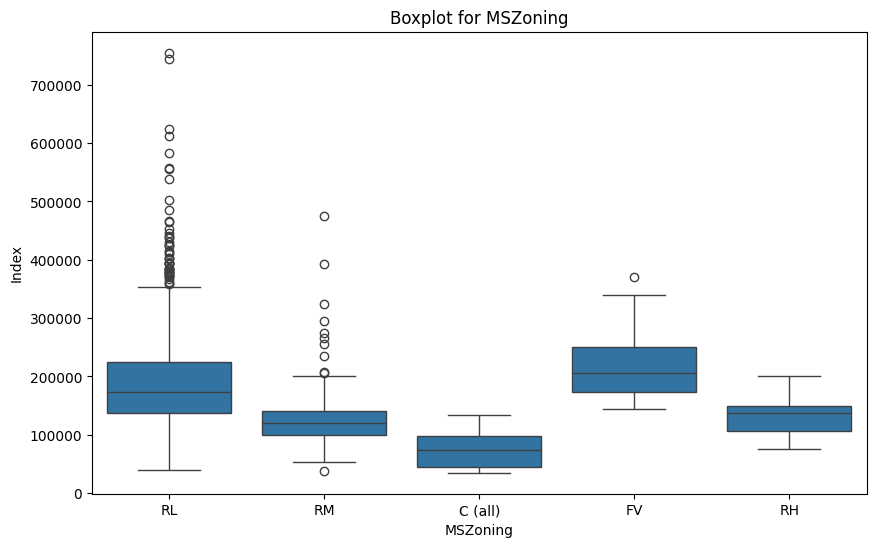

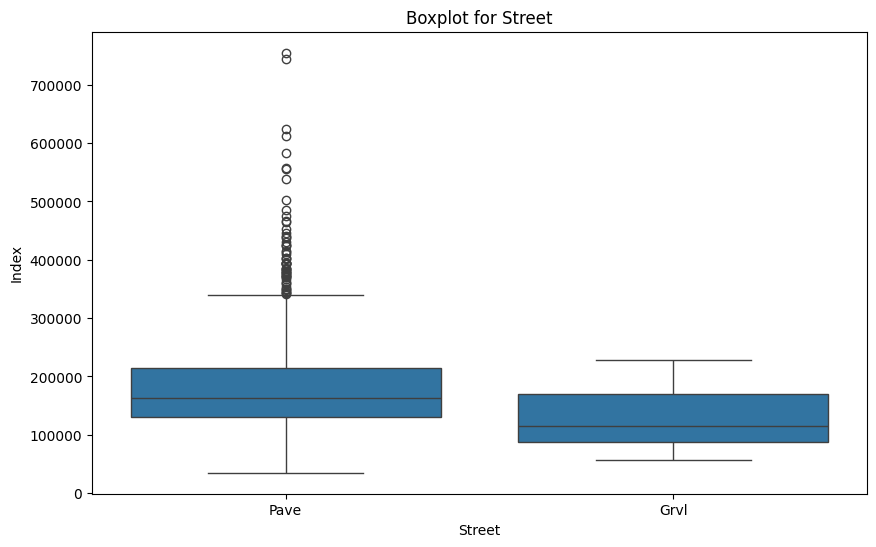

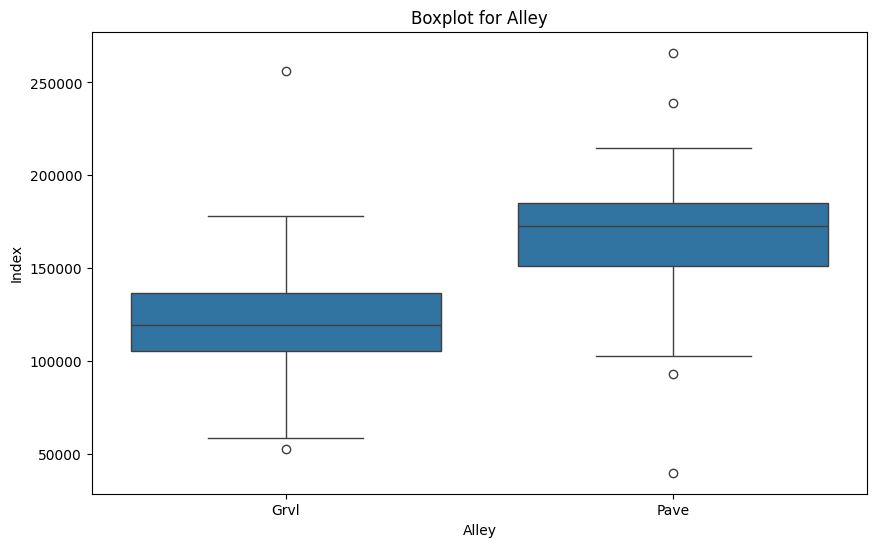

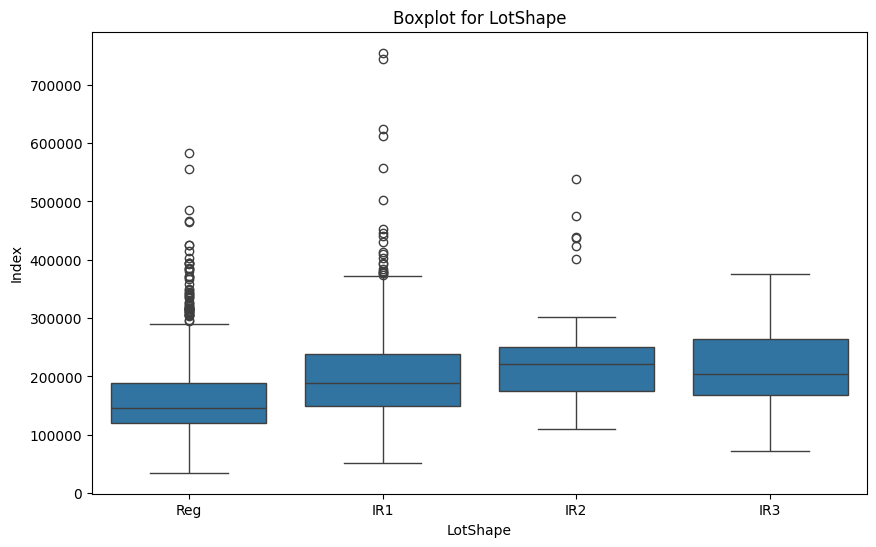

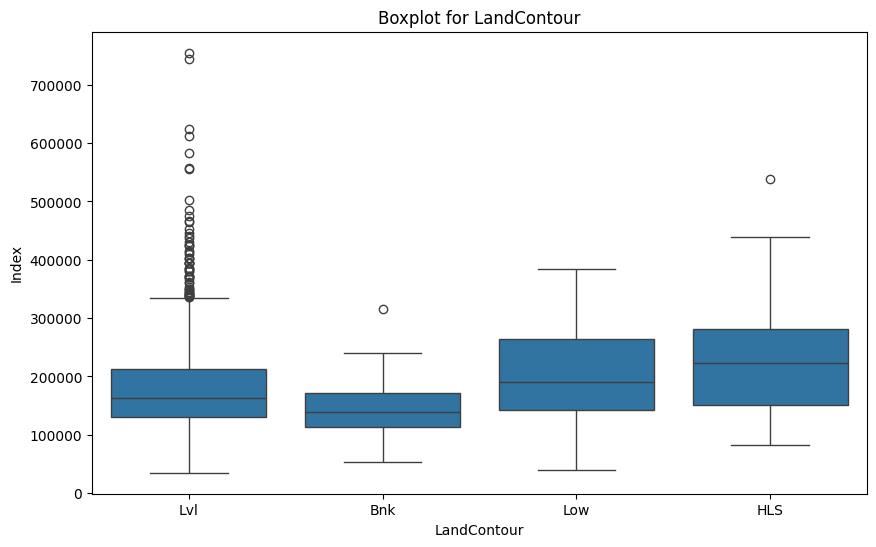

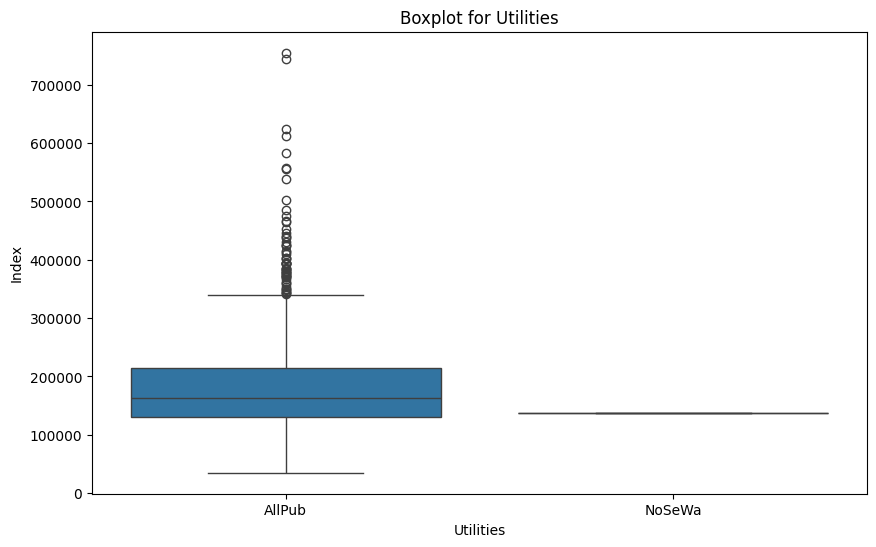

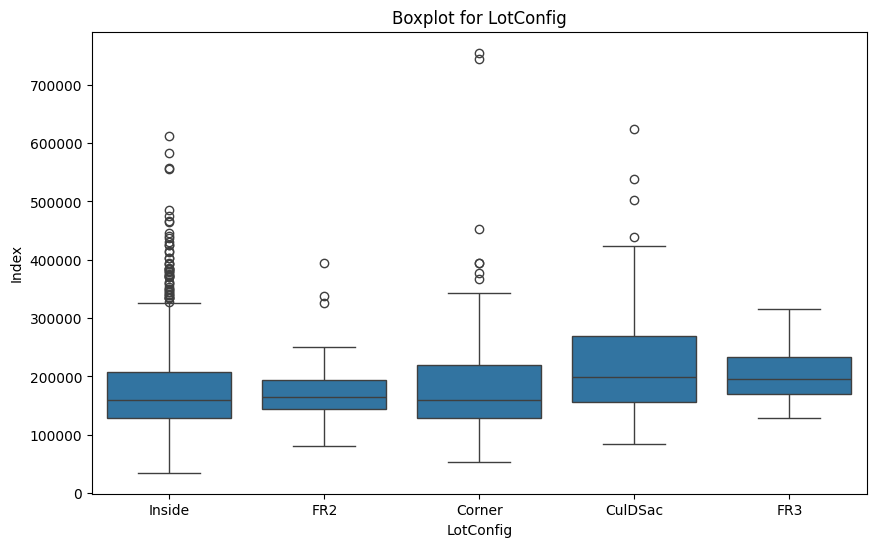

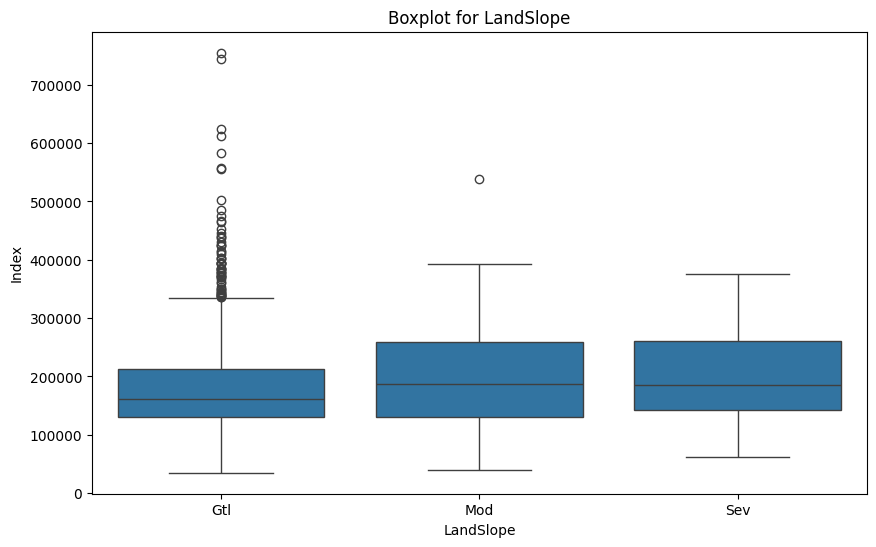

Column 'Neighborhood' has too many unique values to plot.


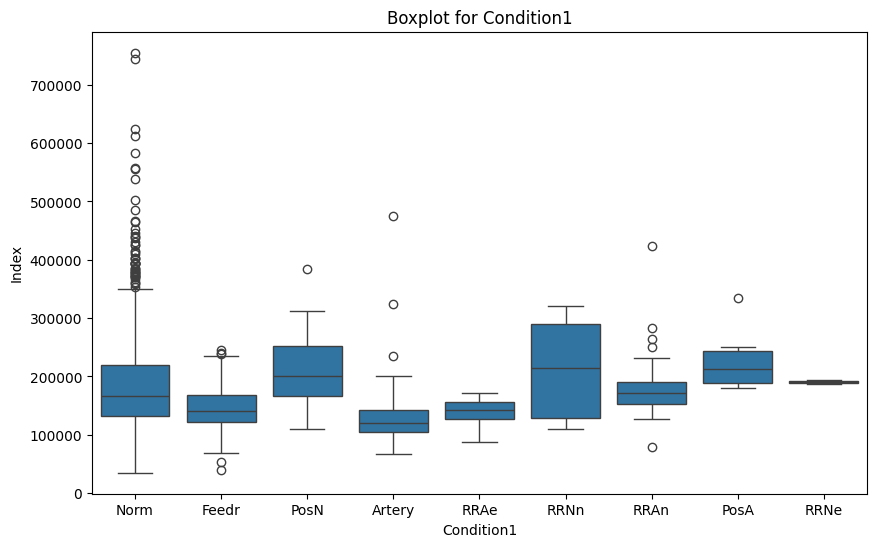

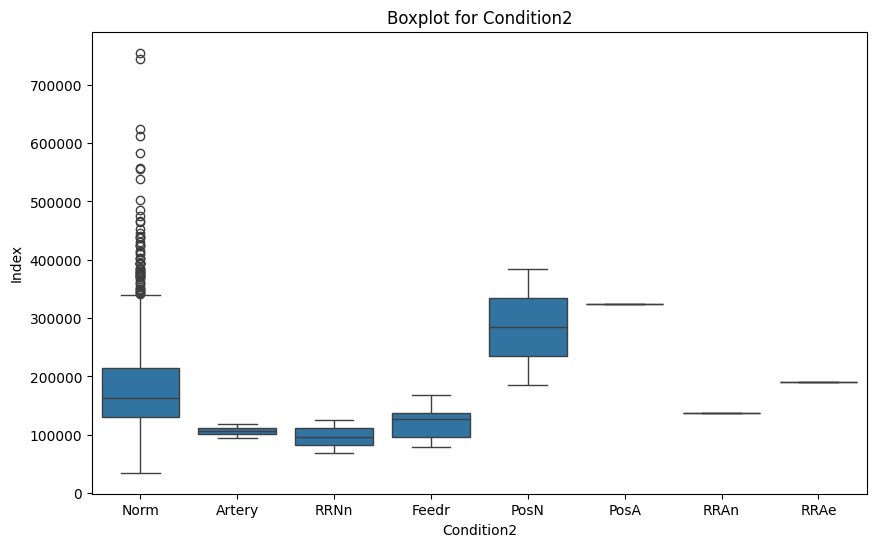

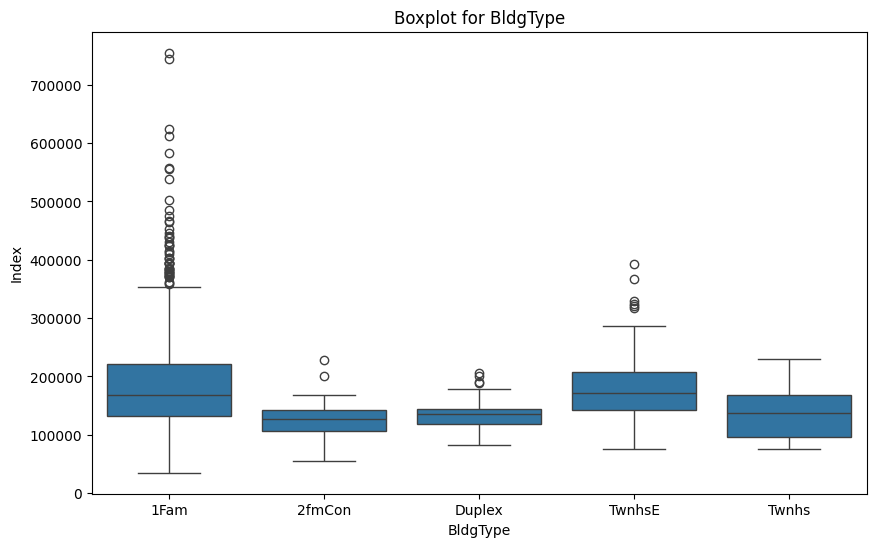

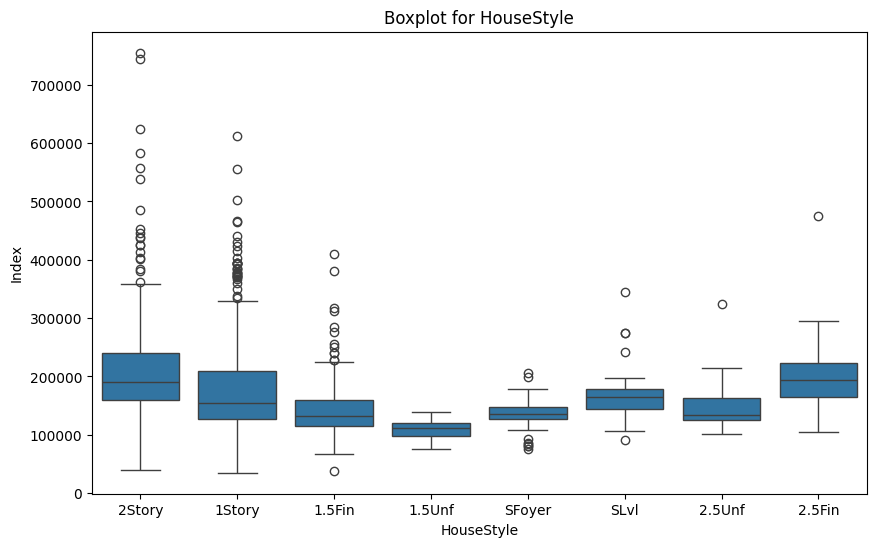

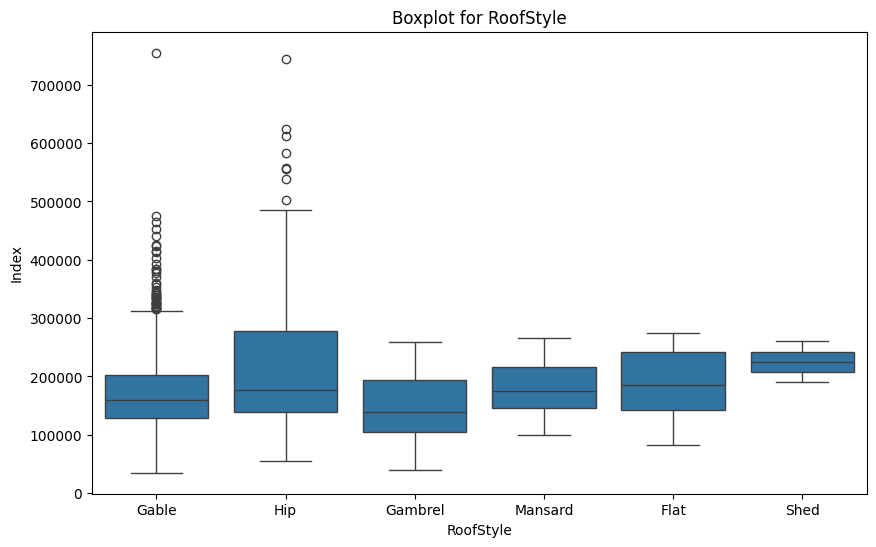

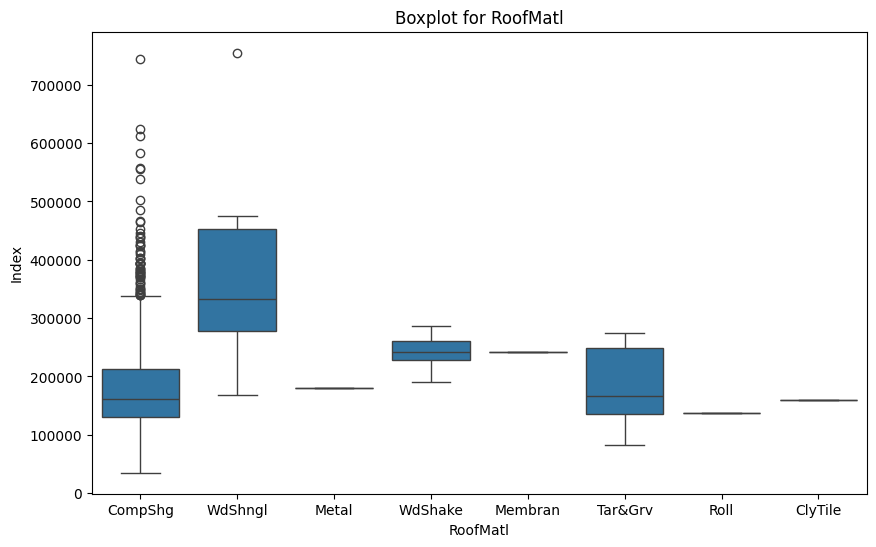

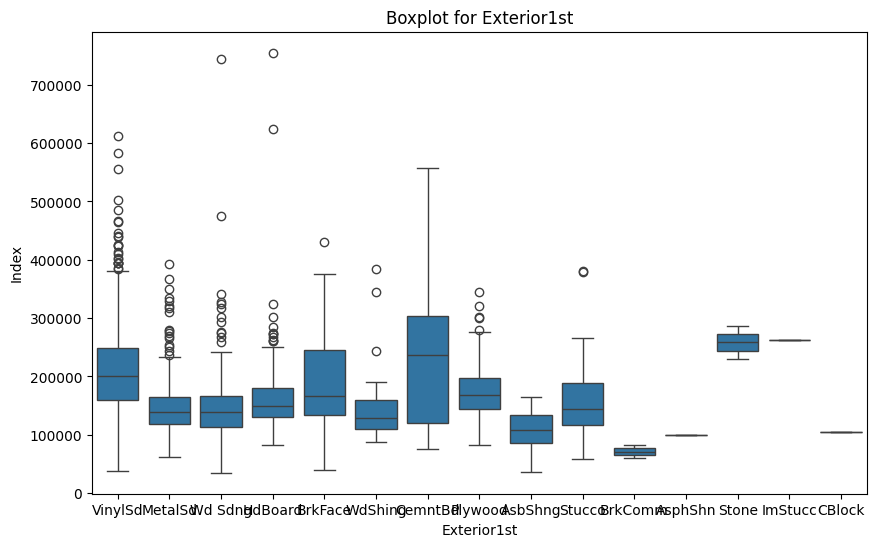

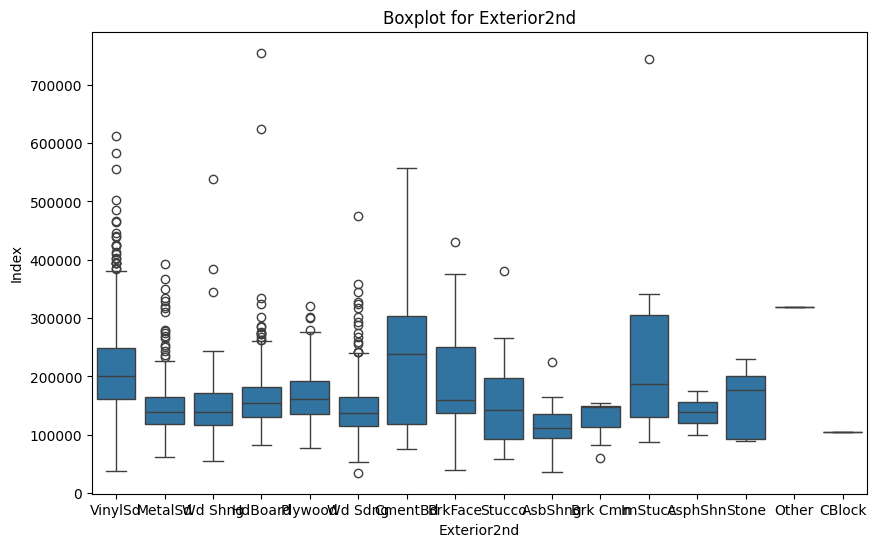

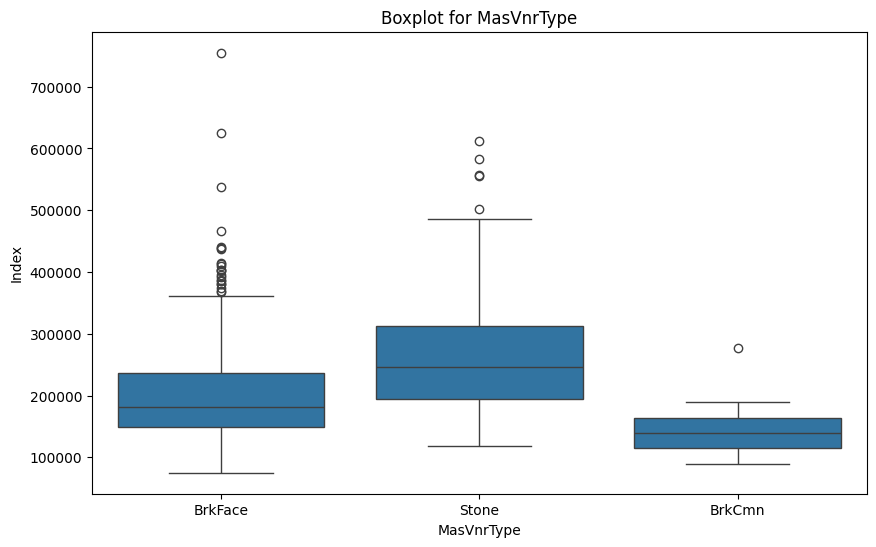

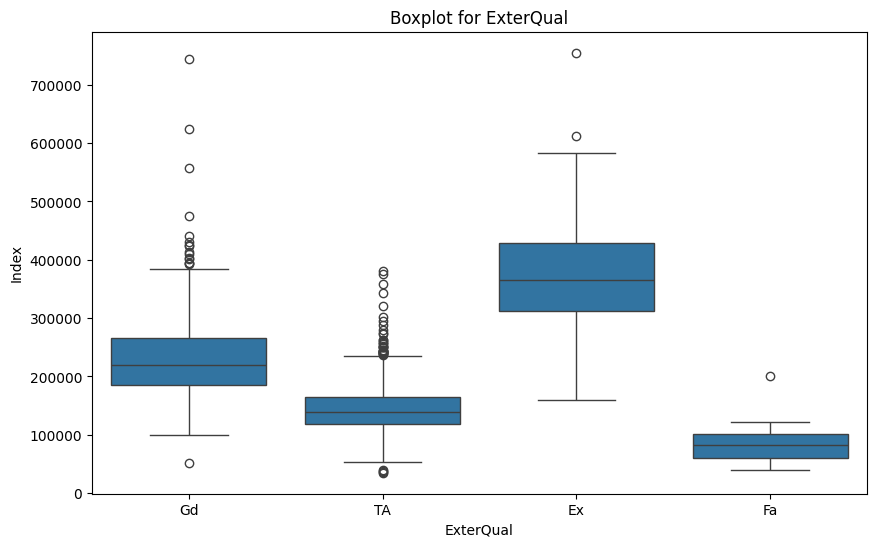

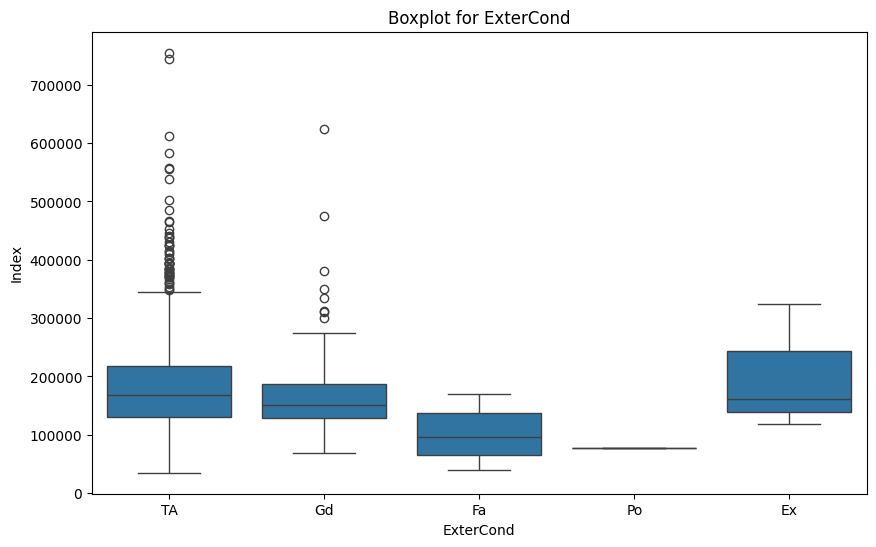

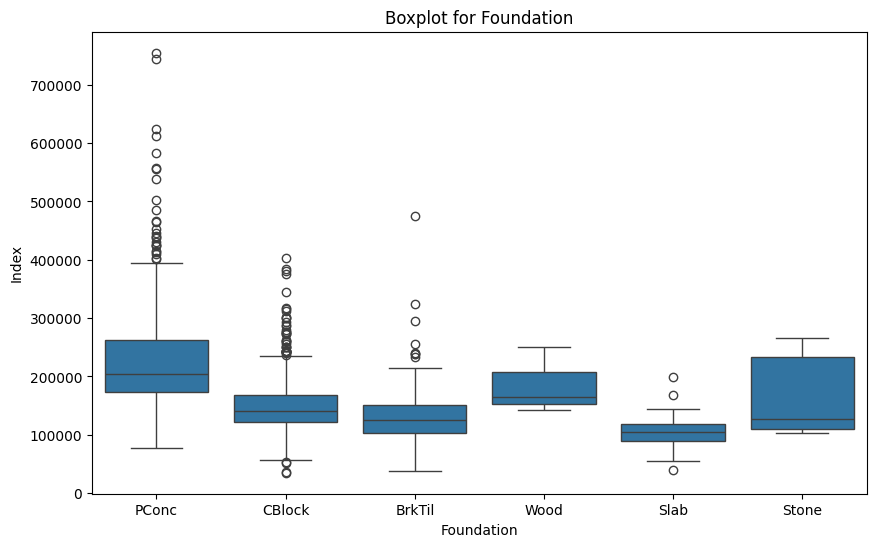

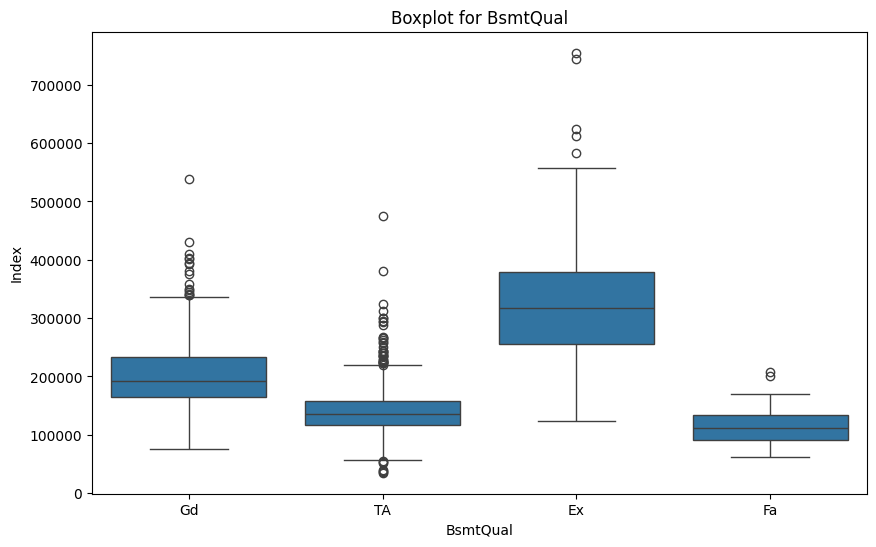

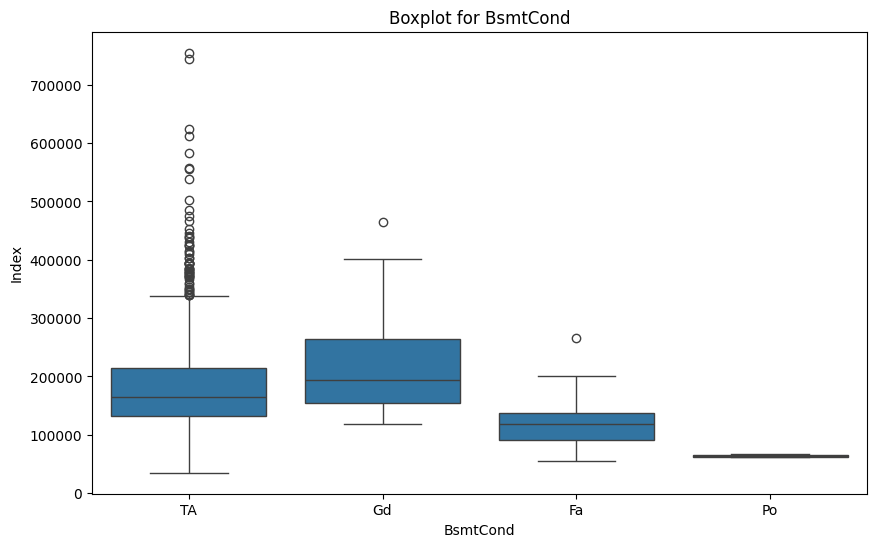

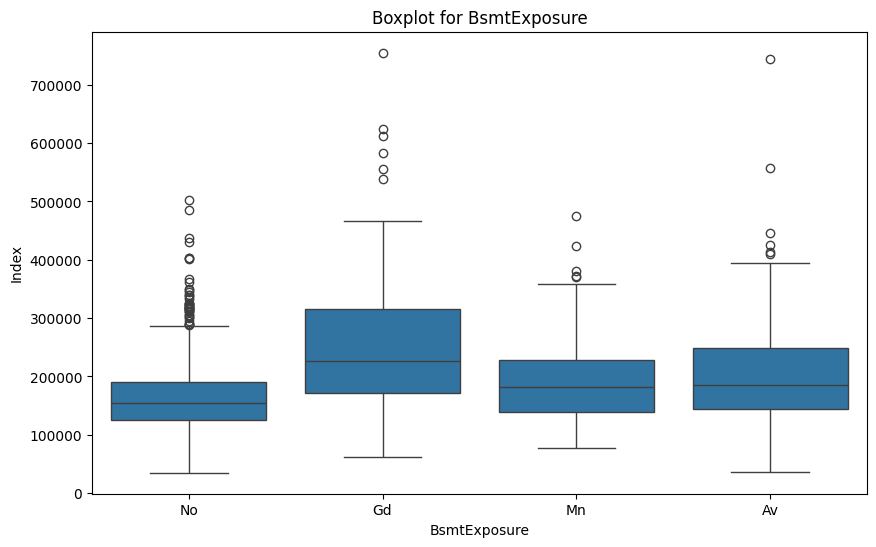

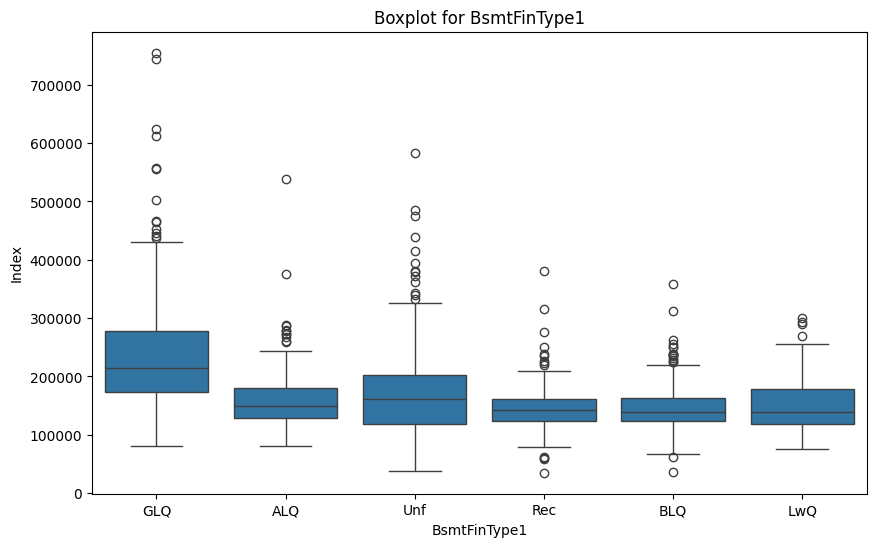

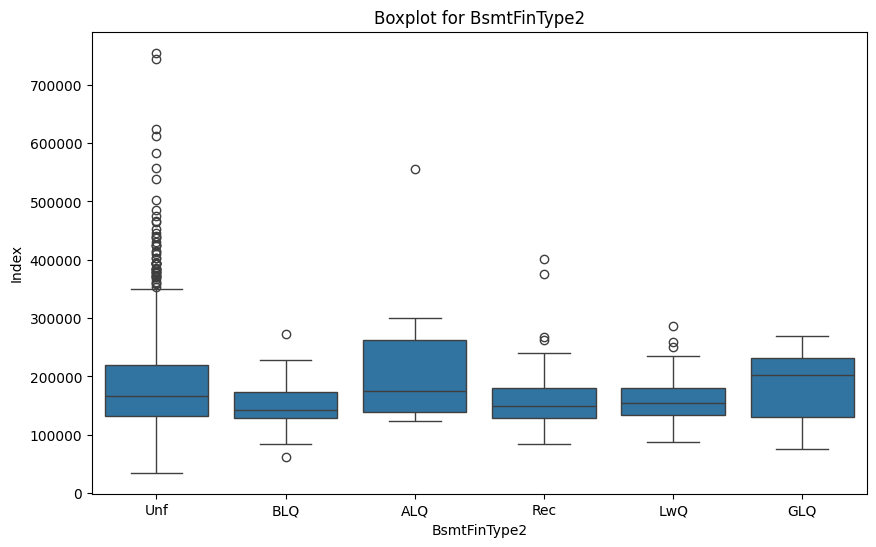

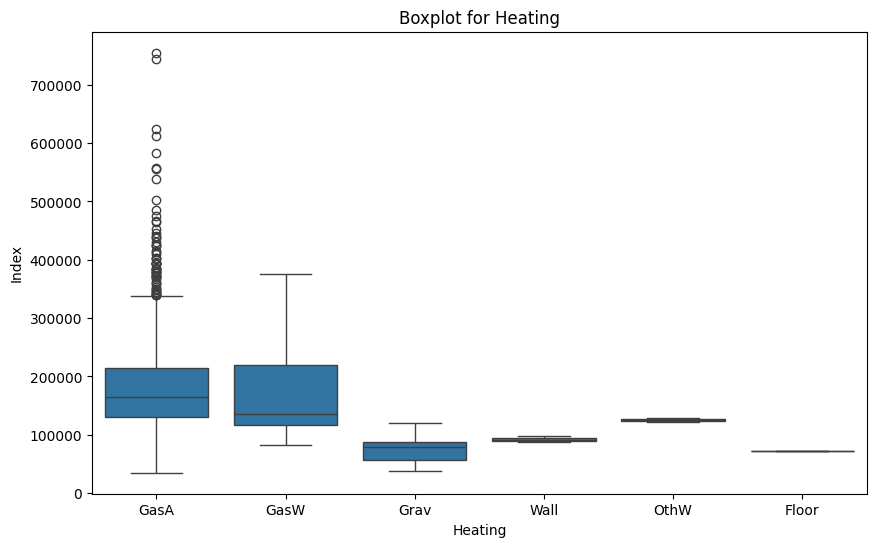

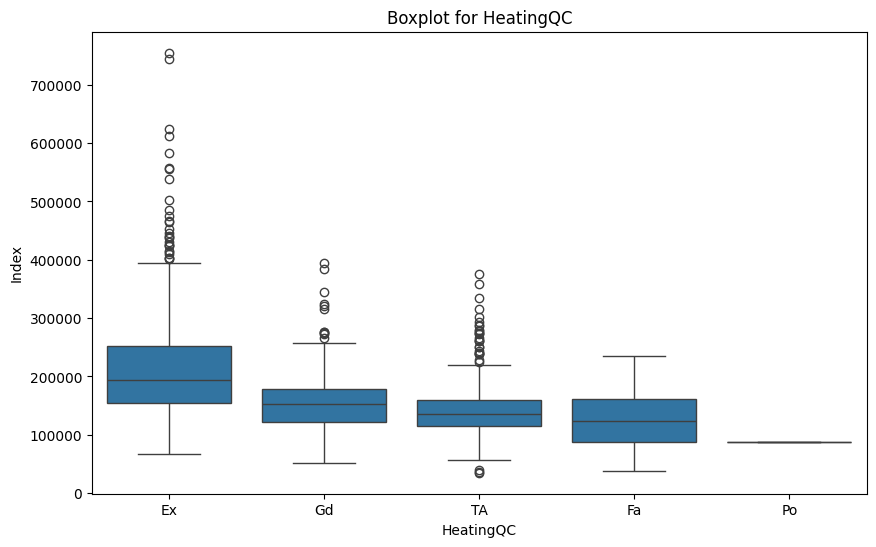

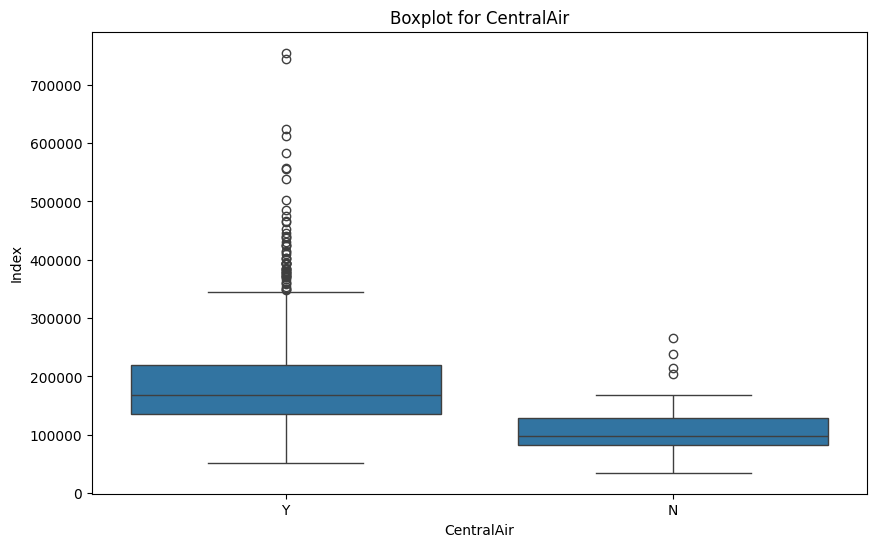

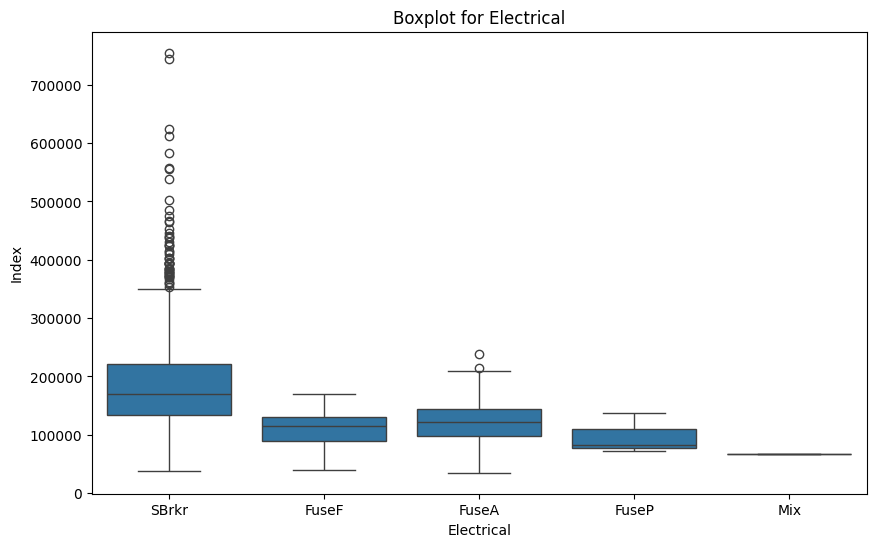

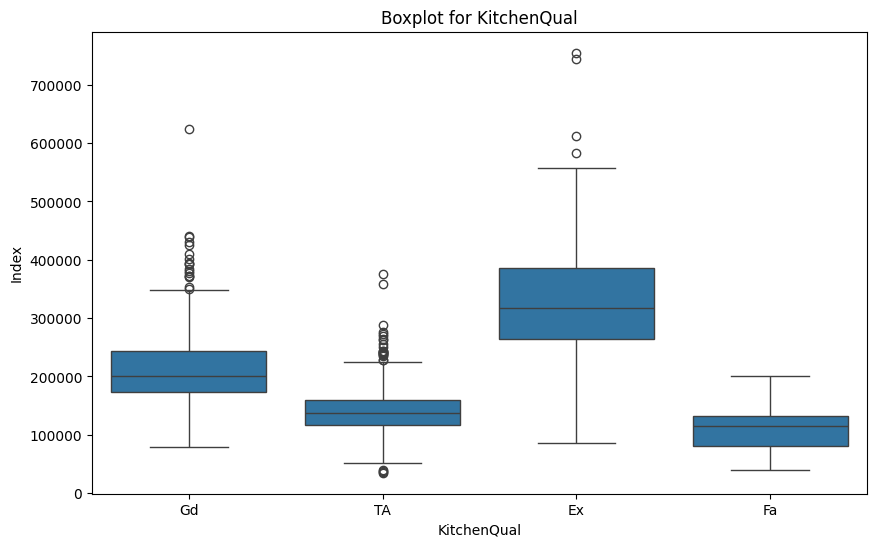

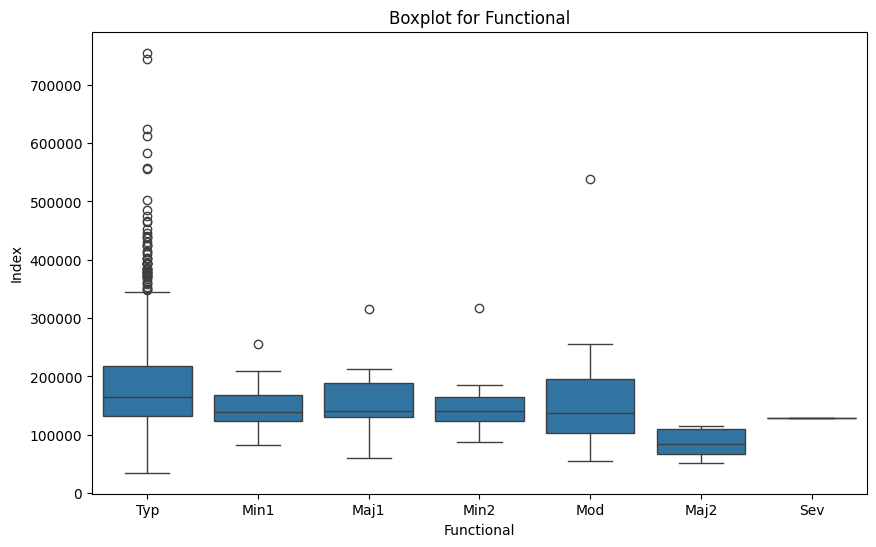

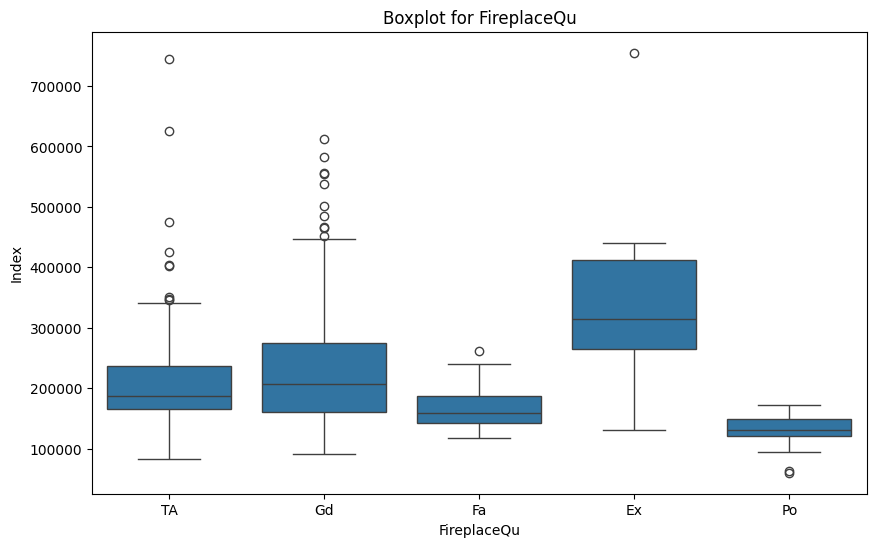

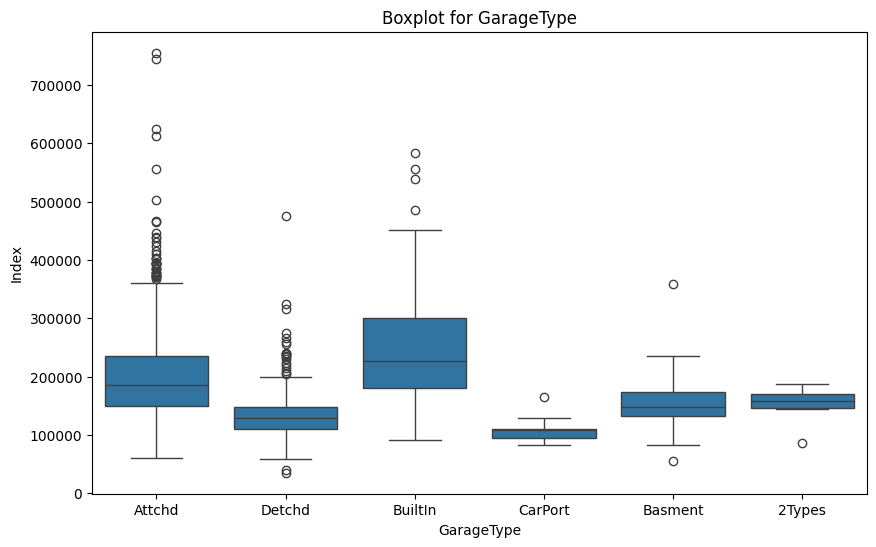

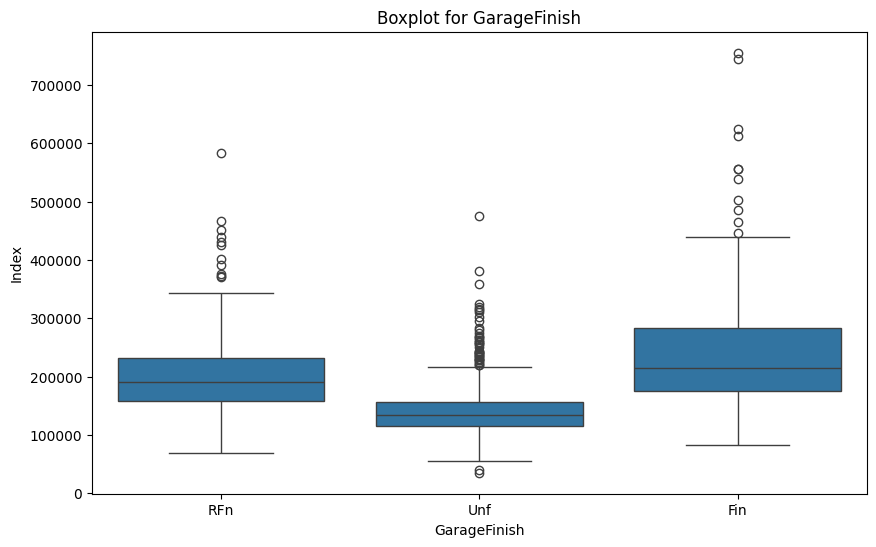

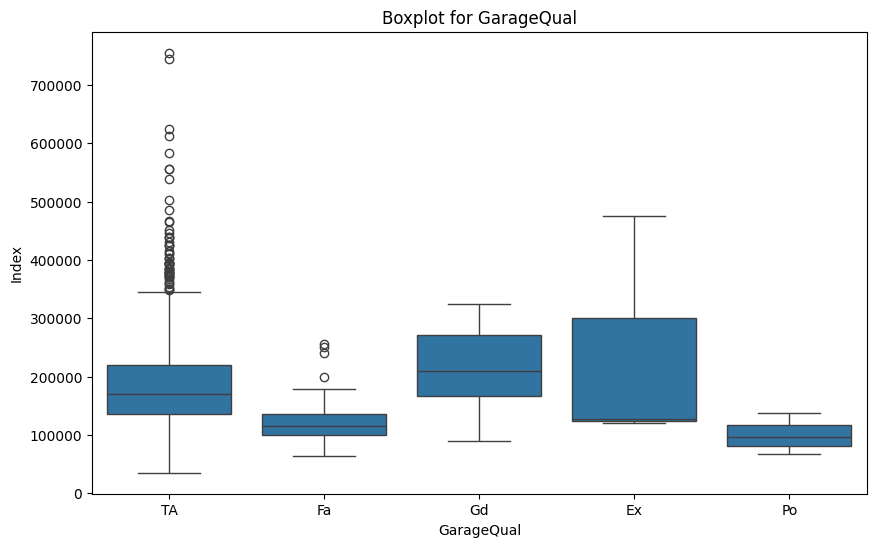

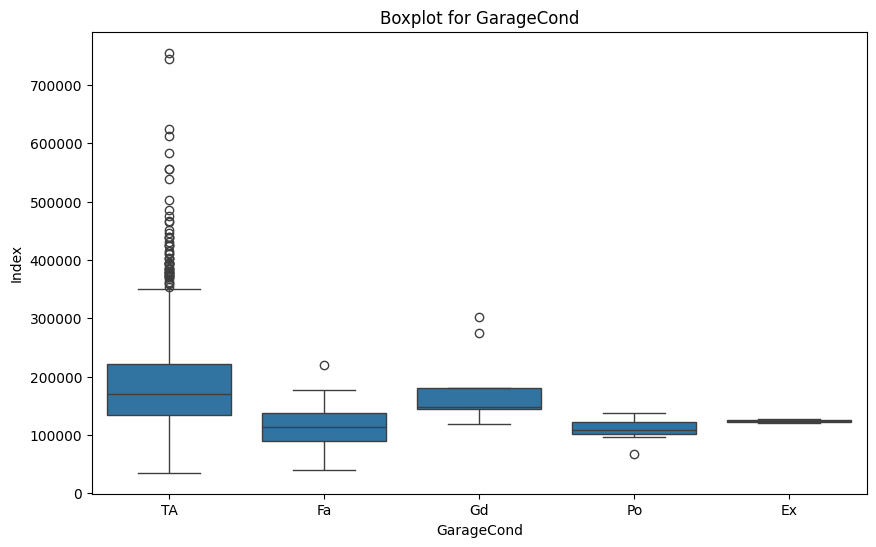

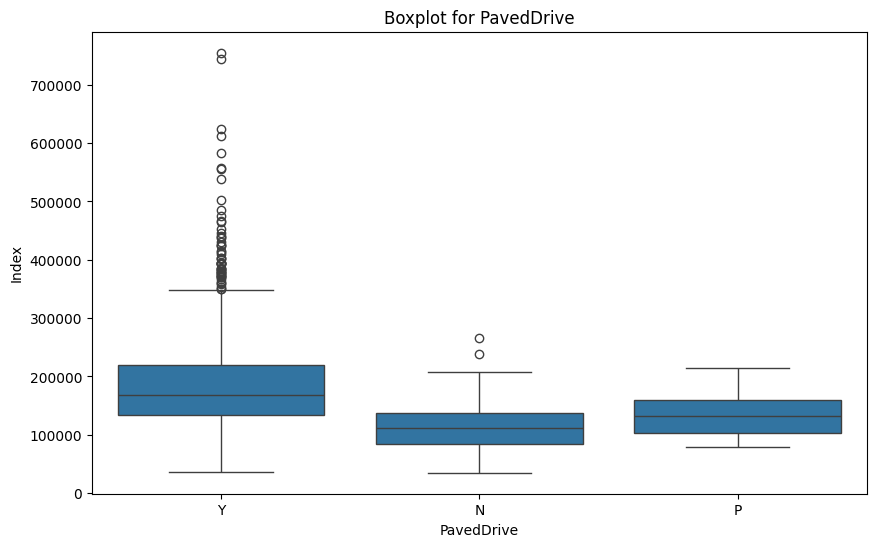

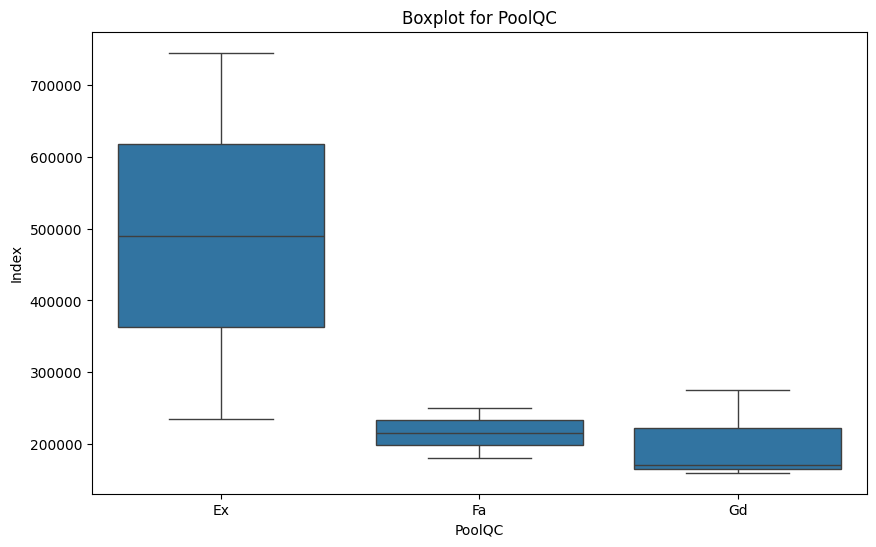

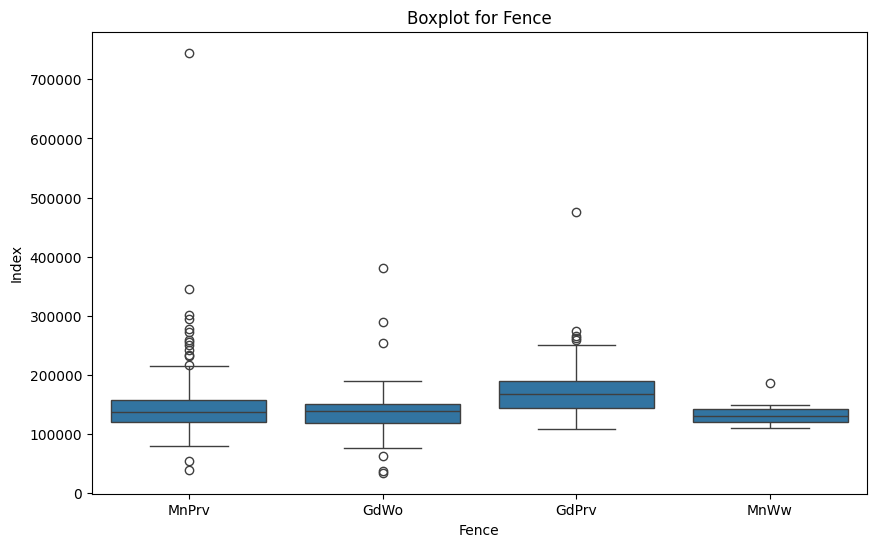

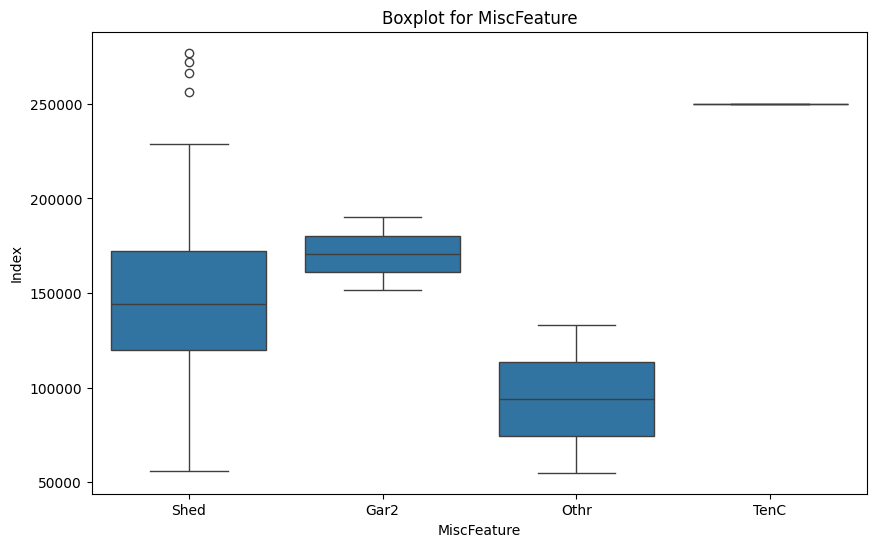

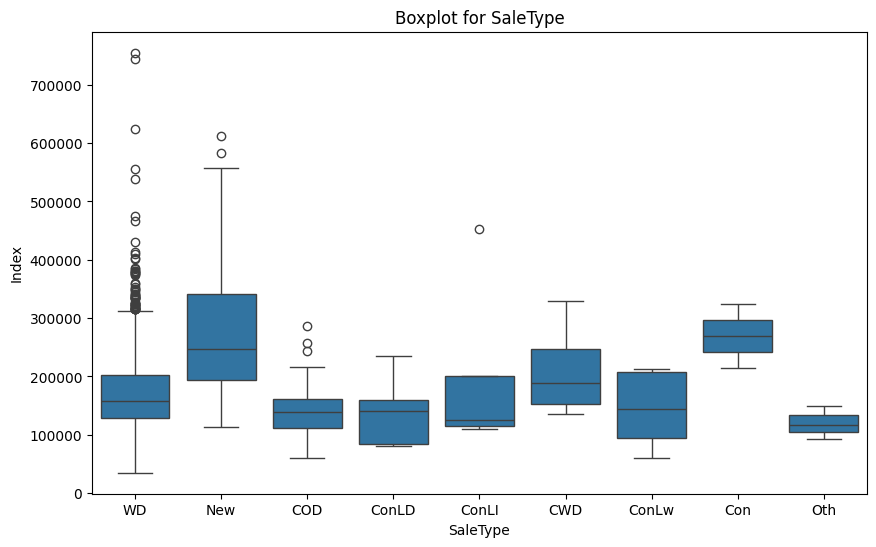

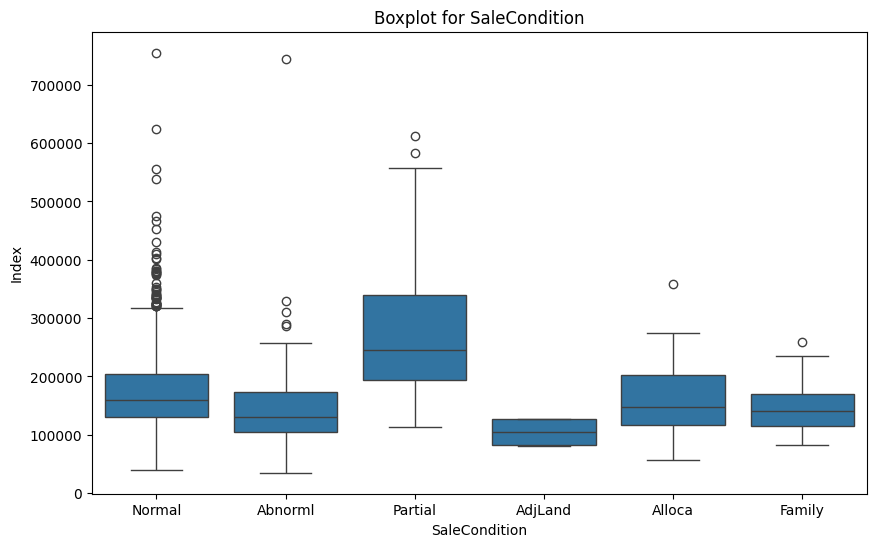

In [4]:
def plot_boxplots_for_object_columns(df):
    object_columns = df.select_dtypes(include=['object']).columns
    
    for column in object_columns:
        if df[column].nunique() < 20:  
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=column, y='SalePrice', data=df)
            plt.title(f'Boxplot for {column}')
            plt.xlabel(column)
            plt.ylabel('Index')
            plt.show()
        else:
            print(f"Column '{column}' has too many unique values to plot.")
            
plot_boxplots_for_object_columns(train_df)

# Find missing values

For simplicity let's combine train and test data into one dataset to find columns with missing values.

In [5]:
mv_check = pd.concat([train_df, test_df])
mv_check.isnull().sum().loc[mv_check.isnull().sum() > 0]

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType      1766
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
SalePrice       1459
dtype: int64

In [6]:
columns_with_nan = [
    'MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
    'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
    'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional',
    'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
    'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'Electrical'
]

Now we have the names of columns with missing data. Let's fill it. <br>
To fill the missing values i am going use simple methods of imputing(mode, median, mean and etc), but before, we also need to read the description of the data to understan the nature of missing values. <br><br>
Alley, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PoolQC, Fence, MiscFeature, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2 = na means a house does not have it, according to the description.

In [7]:
#SecondFloor
train_df['SecondFloor'] = train_df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
test_df['SecondFloor'] = test_df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

#house age
train_df['HouseAge'] =  train_df['YrSold'] - train_df['YearBuilt']
test_df['HouseAge'] =  test_df['YrSold'] - test_df['YearBuilt']

#Total Porch
train_df['TotalPorch'] = train_df['OpenPorchSF'] + train_df['EnclosedPorch'] + train_df['3SsnPorch'] + train_df['ScreenPorch']
test_df['TotalPorch'] = test_df['OpenPorchSF'] + test_df['EnclosedPorch'] + test_df['3SsnPorch'] + test_df['ScreenPorch']

# Data cleaning

A major part of the data is categorical. <br>
To find  outliers we need the numeric continuous data.

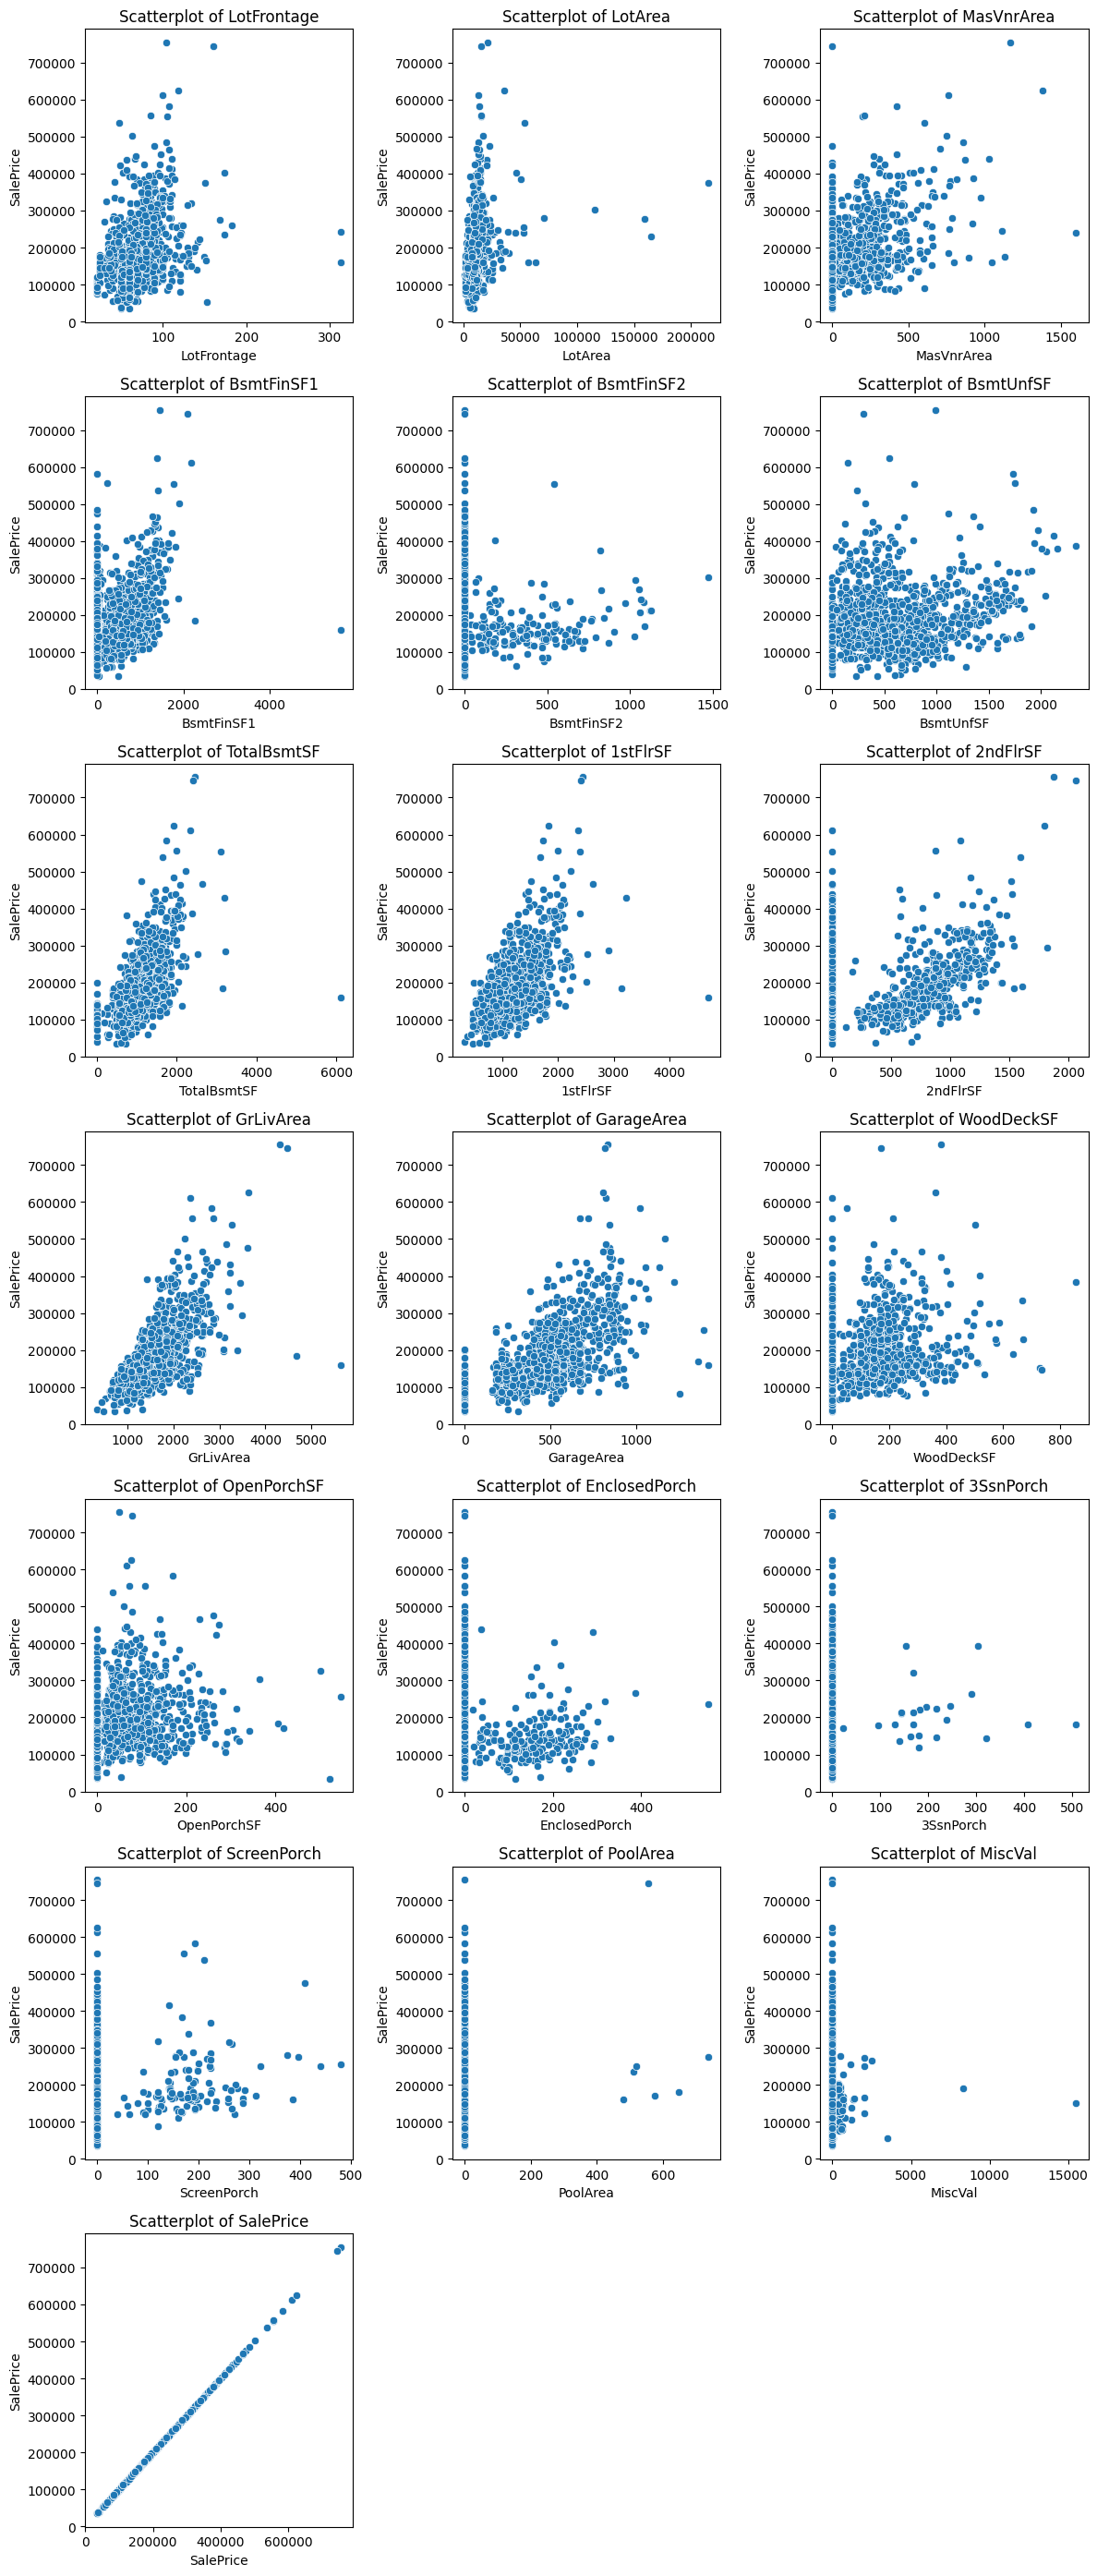

In [8]:
numeric_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
                    'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
                    'GarageArea','WoodDeckSF', 'OpenPorchSF', 
                    'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
                    'PoolArea', 'MiscVal', 'SalePrice' ]

n_cols = 3
n_rows = (len(numeric_features) + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the columns and generate scatterplots
#Scatterplots show the correlation betwwen the features and otliers 
for i, col in enumerate(numeric_features):
    sns.scatterplot(data=train_df, x=col, y='SalePrice', ax=axes[i], )
    axes[i].set_title(f'Scatterplot of {col}')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='SalePrice'>

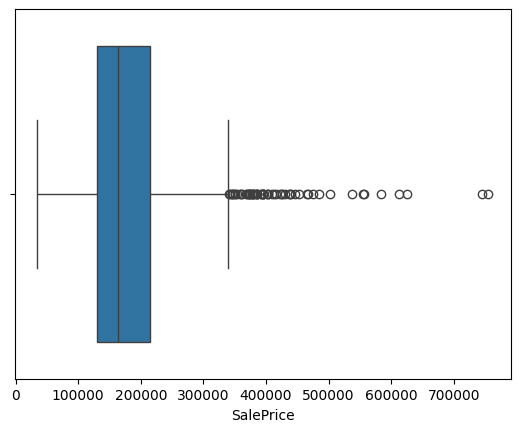

In [9]:
#Also show the SalePrice column
sns.boxplot(data=train_df, x='SalePrice')

SalePrice > 700000, LotFrintage  > 300 look very different, LotArea > 100000, MasVnrArea > 1500, BsmtFinSF1 > 4000, BsmtFinSF1 > 1500, TotalBsmtSF > 6000, lstFlrSF > 4000,
GrLivArea > 4000, GarageArea(SalePrice)>700000, OpenPorchSF>400, 

In [10]:
for_remove = pd.DataFrame()
for_remove = pd.concat([train_df.loc[train_df['SalePrice'] > 700000]], ignore_index=True)
for_remove = pd.concat([for_remove, train_df.loc[train_df['LotFrontage'] > 300]], ignore_index=True)
for_remove = pd.concat([for_remove, train_df.loc[train_df['LotArea'] > 100000]], ignore_index=True)
for_remove = pd.concat([for_remove, train_df.loc[train_df['MasVnrArea'] > 1500]], ignore_index=True)
for_remove = pd.concat([for_remove, train_df.loc[train_df['BsmtFinSF1'] > 4000]], ignore_index=True)
for_remove = pd.concat([for_remove, train_df.loc[train_df['TotalBsmtSF'] > 6000]], ignore_index=True)
for_remove = pd.concat([for_remove, train_df.loc[train_df['GrLivArea'] > 4000]], ignore_index=True)
for_remove = pd.concat([for_remove, train_df.loc[train_df['1stFlrSF'] > 4000]], ignore_index=True)
for_remove = pd.concat([for_remove, train_df.loc[train_df['OpenPorchSF'] > 400]], ignore_index=True)
id_list_for_remove = for_remove['Id'].to_list()

<AxesSubplot:>

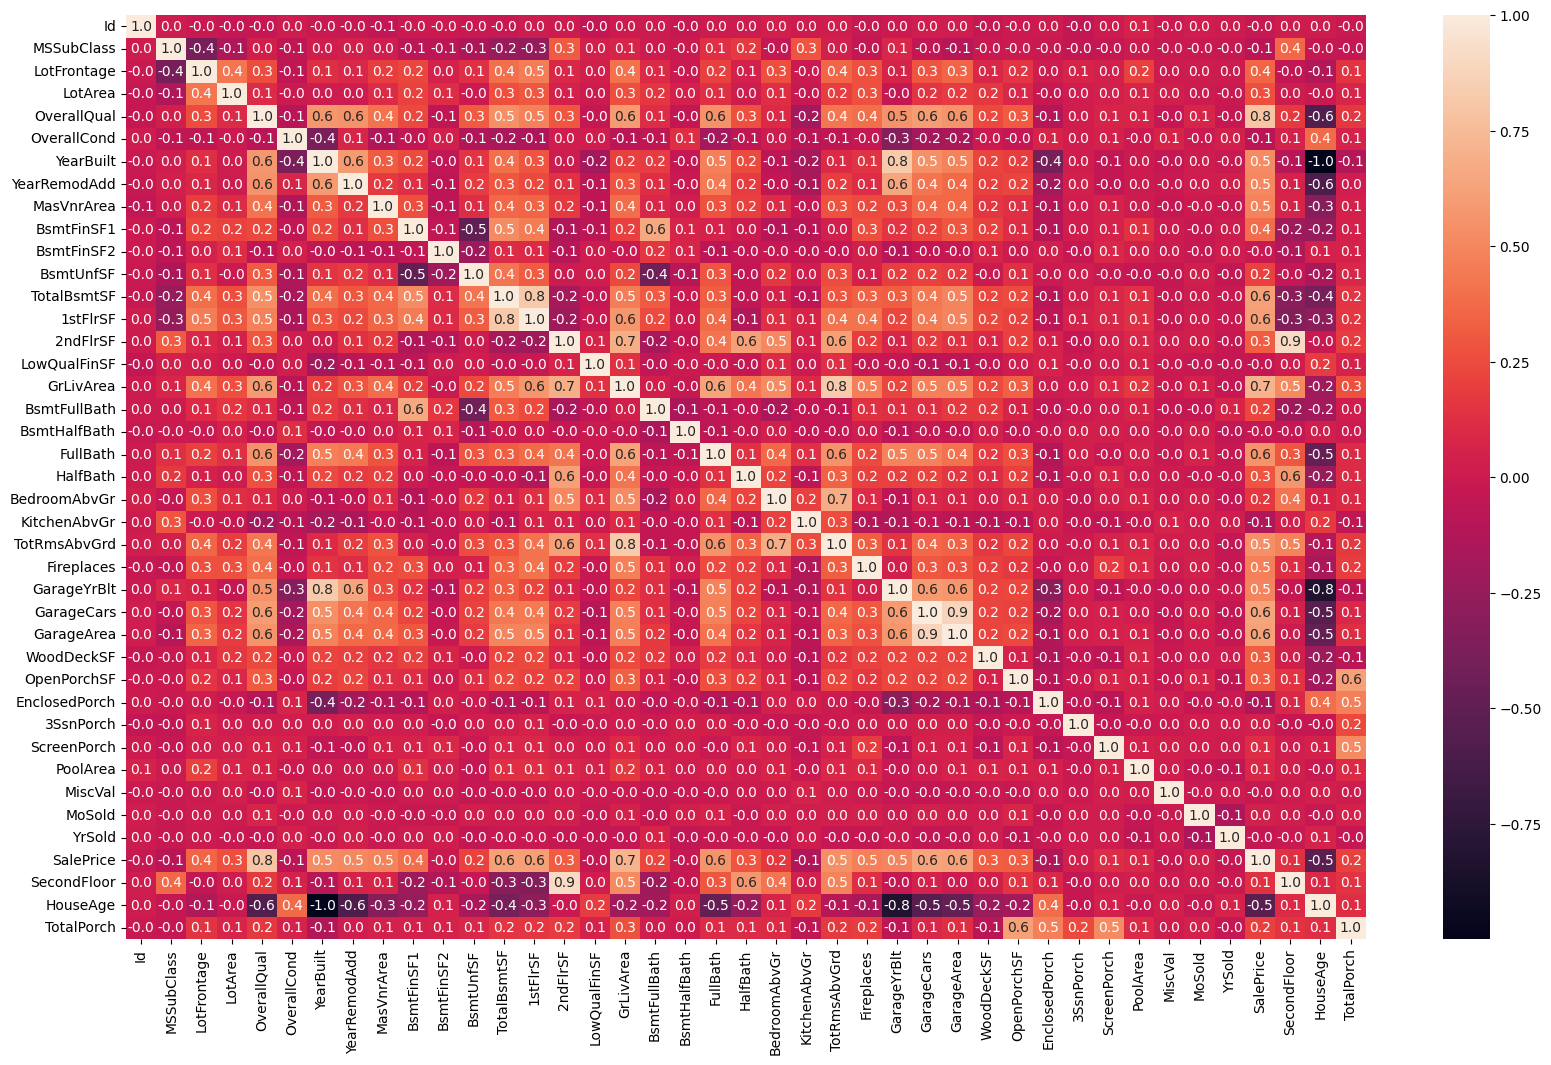

In [11]:
#Let's check the correlation between the features
correlation_matrix = train_df.corr(numeric_only=True)
plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix, annot=True, fmt=".1f")

# Pipeline

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class fill_na(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.fillna({
        'MSZoning': X['MSZoning'].mode()[0],
        'KitchenQual': X['KitchenQual'].mode()[0],
        'Functional': X['Functional'].mode()[0],
        'Exterior1st': X['Exterior1st'].mode()[0],
        'Exterior2nd': X['Exterior2nd'].mode()[0],
        'SaleType': X['SaleType'].mode()[0],    
        'Electrical':  X['SaleType'].mode()[0],
        'Alley': 'None',
        'Utilities': 'None',
        'MasVnrType': 'None',
        'BsmtQual': 'None',
        'BsmtCond': 'None',
        'BsmtExposure': 'None',
        'BsmtFinType1': 'None',
        'BsmtFinType2': 'None',
        'GarageQual': 'None',
        'GarageCond': 'None',
        'PoolQC': 'None',
        'Fence': 'None',
        'MiscFeature': 'None',
        'GarageFinish': 'None',
        'FireplaceQu': 'None',
        'GarageType': 'None',
        'GarageFinish': 'None',
        'BsmtFinSF1': 0,
        'BsmtFinSF2': 0,
        'BsmtUnfSF': 0,
        'TotalBsmtSF0': 0,
        'TotalBsmtSF': 0,
        'BsmtFullBath': 0,
        'BsmtHalfBath': 0,
        'MasVnrArea': 0,
        'LotFrontage': 0, 
        'GarageYrBlt': 0,
        'GarageCars': 0,
        'GarageArea': 0,
              })
        


class clean(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #Remove outliers 
        outliers_id = [692,1183, 935, 1299, 250, 314, 336, 707, 298,1299, 1299, 524, 692, 1183, 1299, 1299, 496, 524, 584, 855, 1329]
        X.drop(X[X['Id'].isin(outliers_id)].index, inplace = True)

        #Some features have almost zero correlation with anothers features, solet's select them and remove them.
        weak_cor = ['Id']
        
        #Remove columns with weak correlation
        X.drop(columns=weak_cor, inplace=True)
        
        return X


class encoding(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #One-hot encoding
        one_hot_encoding = ['LotShape', 'LandContour', 'LotConfig', 'Condition1', 'BldgType', 
                                      'Foundation' , 'GarageType']

        X = pd.get_dummies(X, columns=one_hot_encoding, drop_first=True)
        
        #label encoding
        label_encoding = X.select_dtypes(include=['object']).columns.tolist()

        enc = OrdinalEncoder()
        X[label_encoding] = enc.fit_transform(X[label_encoding])
        
        return X


class feature_engineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #SecondFloor
        X['SecondFloor'] = X['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

        #house age
        X['HouseAge'] =  X['YrSold'] - X['YearBuilt']
        
        #Total Porch
        X['TotalPorch'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['3SsnPorch'] + X['ScreenPorch']     

        #Pool
        X['Pool'] = X['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
        return X

# Data Preparation

In [13]:
train_df = pd.read_csv(train_path)

pipe = Pipeline([
    ('fill_na', fill_na()),
    ('create_new_features', feature_engineering()),
    ('drop_columns', clean()),
    ('label_encoding', encoding())
])
train_df = pipe.fit_transform(train_df)

X = train_df.drop(columns='SalePrice')
y = train_df.SalePrice

# Model

In [14]:
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)


def choose_model(X, y):
    
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(),
        'Gradient Boosting': GradientBoostingRegressor(),
        'XGBoost Regressor': XGBRegressor(),
        'Ridge Regression' : Ridge(),
        'Lasso Regression' : Lasso(),
        'ElasticNet Regression' : ElasticNet(),
        'Desicion Tree Regressor' : DecisionTreeRegressor(),
        'SVM Regressor' : SVR(),
    }
    
    # Define custom scorers for cross_val_score
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    rmse_scorer = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5, greater_is_better=False)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    r2_scorer = make_scorer(r2_score)
    
    # Evaluate each model using cross-validation and store the results
    results = []
    for name, model in models.items():
        mse_scores = cross_val_score(model, X, y, cv=5, scoring=mse_scorer)
        rmse_scores = cross_val_score(model, X, y, cv=5, scoring=rmse_scorer)
        mae_scores = cross_val_score(model, X, y, cv=5, scoring=mae_scorer)
        r2_scores = cross_val_score(model, X, y, cv=5, scoring=r2_scorer)
        
        mean_mse = -np.mean(mse_scores)  # Since cross_val_score returns negative MSE
        mean_rmse = -np.mean(rmse_scores)  # Since cross_val_score returns negative RMSE
        mean_mae = -np.mean(mae_scores)  # Since cross_val_score returns negative MAE
        mean_r2 = np.mean(r2_scores)
        
        results.append((name, mean_mse, mean_rmse, mean_mae, mean_r2))
    
    # Sort the results by mean MSE in ascending order
    results.sort(key=lambda x: x[1])
    
    # Print the sorted results
    print(f'{"Model":<25} {"MSE":<15} {"RMSE":<15} {"MAE":<15} {"R²":<15}')
    print('-' * 70)
    for name, mean_mse, mean_rmse, mean_mae, mean_r2 in results:
        print(f'{name:<25} {mean_mse:<15.4f} {mean_rmse:<15.4f} {mean_mae:<15.4f} {mean_r2:<15.4f}')

choose_model(X, y)

Model                     MSE             RMSE            MAE             R²             
----------------------------------------------------------------------
Gradient Boosting         543851184.1143  23275.5667      15600.1388      0.9063         
Ridge Regression          647808764.0282  25438.8866      17682.1057      0.8877         
Lasso Regression          653521115.0491  25549.5968      17762.5375      0.8868         
Linear Regression         653974608.9382  25557.7363      17761.0485      0.8867         
Random Forest             670096903.3181  25931.4246      16818.0485      0.8812         
XGBoost Regressor         676306759.0066  25969.3822      17112.4404      0.8831         
ElasticNet Regression     707237510.2165  26557.9431      17979.4430      0.8772         
Desicion Tree Regressor   1515676443.5838 38897.1571      26314.5980      0.7454         
SVM Regressor             6145174269.6203 78273.1430      54512.2930      -0.0545        


# Fine-tuning

In [15]:
# Code for finetuning the model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


gbr = GradientBoostingRegressor(random_state=42)
param_grid = {
    'n_estimators': [200, 300, 500, 700],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best parameters found: ", best_params)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rsme = mean_squared_error(y_test, y_pred)**0.5
r_2 = r2_score(y_test, y_pred)
print("MSE on test set: ", mse)
print("RSME on test set: ", rsme)
print("R2 on test set: ", r_2)


Fitting 3 folds for each of 324 candidates, totalling 972 fits


Fitting 3 folds for each of 324 candidates, totalling 972 fits <br>
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500<br>}
MSE on test set:  395250935.822555<br>96
RSME on test set:  19880.91888778<br>172
R2 on test set:  0.921043193939<br><br>
7092
After fine-tuning we got a better result, now let's mobe to the next step and create the finish model.

# Submission

In [ ]:
#Submission
test_df = pipe.fit_transform(test_df)

finished_model = GradientBoostingRegressor(random_state=42, learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=500)
finished_model.fit(X, y)

y_test_pred = finished_model.predict(test_df)

submission = pd.DataFrame({'Id': range(1461, 2919 + 1), 'SalePrice': y_test_pred})
submission.to_csv('submission.csv', index=False)

In [ ]:
submission

,Id,SalePrice
0,1461,117702.027102
1,1462,169000.779071
2,1463,178376.216477
3,1464,187975.652167
4,1465,184984.919179
...,...,...
1454,2915,74149.416859
1455,2916,72448.583880
1456,2917,172156.092135
1457,2918,114952.904926
